# Author: Yoonhyuck WOO / JBNU_Industrial Information system Engineering
# Date; 3. 7. 2022 - 3. 17. 2022
# Title: Korean_NER
# Professor: Seung-Hoon Na

In [1]:
from torch import cuda

device = 'cuda' if cuda.is_available() else 'cpu'

print(device)

cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
pip install transformers

In [4]:
import os
import json
import numpy as np
from functools import partial
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel, FlaubertModel
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# BertTokenizer
 - return tensors = "pt" : Finally, you want the tokenizer to return the actual tensors that are fed to the model.
 
# BertModel
 - Attention_mask : 1 where you care and 0 where you don't care.
 - Input_ids : the IDs of the sentence morpheme.
 - Token_type_ids : for the question problem, but it's enough to set it to zero now.

reference: https://huggingface.co/docs/transformers/model_doc/bert

# Example

In [5]:
PRETAINED_MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(PRETAINED_MODEL_NAME)

# Loading Data

In [6]:
PATH_dir = '/content/drive/My Drive/Colab Notebooks/Ko_En_NER_POStag_data/Ko_NER_POS/'
PATH_ko_train = os.path.join(PATH_dir, 'prepro_train.json')
PATH_ko_test = os.path.join(PATH_dir, 'prepro_test.json')
PATH_ko_dev = os.path.join(PATH_dir, 'prepro_dev.json')
total_tag = os.path.join(PATH_dir, 'total_tag.json')

In [7]:
with open(PATH_ko_dev) as data_file:
  dataset_dev = json.load(data_file)
with open(PATH_ko_test) as data_file:
  dataset_test = json.load(data_file)
with open(PATH_ko_train) as data_file:
  dataset_train = json.load(data_file) 

In [8]:
print('train', len(dataset_train))
print('test', len(dataset_test))
print('dev', len(dataset_dev))
# tag_converter.id_to_tag

train 4250
test 500
dev 250


# convert_Tag_to_id

In [9]:
def convert_Tag_to_id_list(batch):
  tag_to_id ={'PAD': 0, 'B-<휠': 1, 'B-OG': 2, 'I-조선': 3, 'I-PS': 4, 'B-LC': 5, 'B-1': 6, 'I-<휠': 7, 'I-LC': 8, 'B-PS': 9, 'I-TI': 10, 
              'B-목소': 11, 'O': 12, 'I-목소': 13, 'I-1': 14, 'I-': 15, 'B-조선': 16, 'I-OG': 17, 'B-': 18, 'I-DT': 19, 'B-TI': 20, 'B-DT': 21}
  total = []
  t_to_i = []
  for j in batch:
      j = tag_to_id.get(j)
      t_to_i.append(j)

  return t_to_i

# convert_id_to_tag

In [10]:
def convert_id_to_tag_list(batch):
  id_to_tag ={0: '[PAD]', 1: 'B-<휠', 2: 'B-OG', 3: 'I-조선', 4: 'I-PS', 5: 'B-LC', 6: 'B-1', 7: 'I-<휠', 8: 'I-LC', 9: 'B-PS', 
              10: 'I-TI', 11: 'B-목소', 12: 'O', 13: 'I-목소', 14: 'I-1', 15: 'I-', 16: 'B-조선', 17: 'I-OG', 18: 'B-', 19: 'I-DT', 20: 'B-TI', 21: 'B-DT'}
  total = []
  i_to_t = []
  for j in batch:
      j = id_to_tag.get(j)
      i_to_t.append(j)

  return i_to_t

In [11]:
convert_Tag_to_id_list(['O','I-목소'])

[12, 13]

In [12]:
convert_id_to_tag_list([12, 13])

['O', 'I-목소']

# Make Batch & Padding

In [13]:
def make_batch(labels, max_len):
  batch_labels = []
  special_token = 0

  for taglist in labels:
    sample = [special_token] + convert_Tag_to_id_list(taglist)[:max_len-2] + [special_token]
    sample +=[special_token] * max(0, max_len - (len(sample)))
    batch_labels.append(sample)
    # print(batch_labels)
    
  return torch.tensor(batch_labels)

In [14]:
tag = [['B-OG', 'I-OG', 'I-조선', 'I-OG', 'I-OG', 'I-DT'],  # 0, 2, 17, 3, 17, 17, 19, 0
       ['O', 'B-DT', 'I-DT', 'B-DT', 'I-DT', 'I-DT', 'I-DT', 'I-DT', 'B-LC','O', 'O', 'B-OG', 'I-OG', 'I-OG', 'I-OG'], 
       ['I-OG', 'O', 'O', 'O', 'B-PS', 'O', 'B-PS', 'I-PS', 'I-PS', 'O', 'B-LC', 'O', 'O', 'B-OG',], 
       ['B-PS', 'O', 'O', 'O', 'O', 'O', 'O', 'O','O', 'O', 'O', 'O', 'I-DT','I-PS', 'I-PS']]

In [15]:
make_batch(tag,17)

tensor([[ 0,  2, 17,  3, 17, 17, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 12, 21, 19, 21, 19, 19, 19, 19,  5, 12, 12,  2, 17, 17, 17,  0],
        [ 0, 17, 12, 12, 12,  9, 12,  9,  4,  4, 12,  5, 12, 12,  2,  0,  0],
        [ 0,  9, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 19,  4,  4,  0]])

In [16]:
print(len(tag[0]), len(tag[1]) ,len(tag[2]) ,len(tag[3]))

6 15 14 15


In [17]:
def ner_fn_custom(tokenizer, make_batch, data):
    
    input_sent = [sample[0] for sample in data]
    labels = [sample[2] for sample in data]

    batch_inputs = tokenizer(input_sent, padding = True, return_tensors = "pt")
    batch_labels = make_batch(labels, max_len = batch_inputs['input_ids'].size(1))

    return batch_inputs, batch_labels

In [18]:
batch_size = 15
# partial (func, /, *args, **keywords)  positional argument: args, keyword argument: keywords

# partial_collate_fn = partial(collate_fn_custom, tokenizer, tag_converter)
# partial_collate_fn = collate_fn_custom

partial_collate_fn = partial(ner_fn_custom, tokenizer, make_batch)
'''
partial_collate_fn = partial(collate_fn_custom, tokenizer, tag_converter)
'''
# ner_collate_fn: padding & making batch?
'''
def ner_collate_fn(tokenizer, tag_converter):
    
'''

'\ndef ner_collate_fn(tokenizer, tag_converter):\n    \n'

# DataLoader
- responsible for deployment management
- easier to repeat the arrangement.
- automatically provide individual mini-batch

In [19]:
dataloader_train = DataLoader(
    dataset_train,
    batch_size = batch_size,
    shuffle = True,
    collate_fn = partial_collate_fn)

dataloader_test = DataLoader(
    dataset_test,
    batch_size = batch_size,
    shuffle = False,
    collate_fn = partial_collate_fn)

dataloader_dev = DataLoader(
    dataset_dev,
    batch_size = batch_size,
    shuffle = False,
    collate_fn = partial_collate_fn)

#Bert_NER Model
 - Dropout: method to solve overfitting, one of the problems in deep learning learning. In summary, how to prevent some units of the hidden layer from being overfitted by inoperative<br>
    ->the outputs are scaled by a factor of (1 / 1-p)  during training

# *args, **kargs
 - *args(non-keworded arguments): Tuple type of argument without limitation.
 - **kargs(keworded arguments):  Dictionary type of argument without limitation.

In [20]:
class Bert_NER(nn.Module):  
    def __init__(self, bert):
        super().__init__() 
        bert = BertModel.from_pretrained(PRETAINED_MODEL_NAME)     
        self.bert = bert
        self.dropout = nn.Dropout(p = 0.1)
        self.linear = nn.Linear(768, 22)
        self.softmax = nn.Softmax(dim = 2) # A dimension along which Softmax will be computed
    
    def forward(self, **kwargs):
        emb = self.bert(**kwargs)
        e = self.dropout(emb['last_hidden_state'])
        w = self.linear(e)
        
        return w

In [21]:
# tag_num = len(tag_to_id) # <=22 
'''tag_to_id ={'PAD': 0, 'B-<휠': 1, 'B-OG': 2, 'I-조선': 3, 'I-PS': 4, 'B-LC': 5, 'B-1': 6, 'I-<휠': 7, 'I-LC': 8, 'B-PS': 9, 'I-TI': 10, 
   'B-목소': 11, 'O': 12, 'I-목소': 13, 'I-1': 14, 'I-': 15, 'B-조선': 16, 'I-OG': 17, 'B-': 18, 'I-DT': 19, 'B-TI': 20, 'B-DT': 21}'''
model = Bert_NER(22)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
model.cuda()
device = model.bert.device

In [23]:
print(device)

cuda:0


In [24]:
CELoss = nn.CrossEntropyLoss(ignore_index = 0)
optimizer = AdamW(model.parameters(), lr = 1.0e-4)
draw = []

  9 - loss: 0.06666503846645355
 19 - loss: 0.11377859860658646
 29 - loss: 0.06154070794582367
 39 - loss: 0.0231524296104908
 49 - loss: 0.03685016930103302
 59 - loss: 0.15677466988563538
 69 - loss: 0.07751927524805069
 79 - loss: 0.049141161143779755
 89 - loss: 0.09551391005516052
 99 - loss: 0.09889163821935654
109 - loss: 0.0446753203868866
119 - loss: 0.053119856864213943
129 - loss: 0.1005452424287796
139 - loss: 0.17880405485630035
149 - loss: 0.10608609765768051
159 - loss: 0.16996073722839355
169 - loss: 0.0736631229519844
179 - loss: 0.1373586505651474
189 - loss: 0.20591972768306732
199 - loss: 0.14674384891986847
209 - loss: 0.04732055962085724
219 - loss: 0.1235424056649208
229 - loss: 0.08527322113513947
239 - loss: 0.027471717447042465
249 - loss: 0.16918465495109558
259 - loss: 0.038252752274274826
269 - loss: 0.10018281638622284
279 - loss: 0.08682123571634293


Text(0, 0.5, 'accuracy')

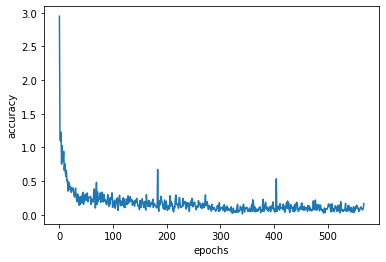

In [26]:
for iteration, batch in enumerate(dataloader_train):
    batch_inputs = {k: v.cuda(device) for k, v in list(batch[0].items())}
    batch_labels = batch[1].cuda(device)

    output = model(**batch_inputs)
    loss = CELoss(output.view(-1, output.size(-1)), batch_labels.view(-1))

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    draw.append(loss.item())
    if (iteration + 1) % 10 == 0:
        print(f'{iteration:3} - loss: {loss.item()}')
plt.plot(draw)
plt.xlabel("epochs")
plt.ylabel("accuracy")

# Test

In [27]:
model.eval()

gold_list = []
pred_list = []

with torch.no_grad():
    for iteration, batch in enumerate(dataloader_test):
        batch_inputs = {k: v.cuda(device) for k, v in list(batch[0].items())}
        batch_labels = batch[1].cuda(device)

        output = model(**batch_inputs)

        loss = CELoss(output.view(-1, output.size(-1)), batch_labels.view(-1))

        print('loss:', loss.item())
        pred_ids = torch.argmax(output, dim = -1)
        
        # print(pred_ids)
        
        for g, p in zip(batch_labels, pred_ids):
            gold_mask = g != 0 #tag_converter.pad_id
            
            gold = convert_id_to_tag_list(g[gold_mask].tolist())
            pred = convert_id_to_tag_list(p[gold_mask].tolist())
            gold_list.append(gold)
            pred_list.append(pred)
            
            print(gold)
            print(pred)

loss: 1.8975913524627686
['B-PS', 'O', 'B-DT', 'I-DT', 'O', 'B-LC', 'O', 'O', 'B-OG', 'I-OG', 'O', 'O', 'O', 'O', 'O', 'B-OG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PS', 'I-PS', 'I-PS', 'I-PS', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['B-PS', 'I-PS', 'I-PS', 'O', 'B-DT', 'I-DT', 'O', 'B-LC', 'O', 'O', 'O', 'B-OG', 'I-OG', 'I-OG', 'I-OG', 'I-OG', 'I-OG', 'I-OG', 'I-OG', 'I-OG', 'I-OG', 'I-OG', 'O', 'O', 'O', 'O', 'O', 'O', 'B-OG', 'I-OG', 'I-OG', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'B-PS', 'I-PS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PS', 'B-PS', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'B-PS', 'I-PS', 'I-PS', 'I-PS', 'I-PS', 'I-PS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PS', 'O']
['O', 'O', 'O', 'B-PS', 'I-PS', 'I-PS', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'B-PS', 'I-PS', 'O']
['O', 'O', 'O', 'B-PS', 'I-PS', 'I-PS']
['B-PS', 'I-PS', 'O', 'O', 'B-PS', 'O', 'O', 'O']
['B-PS'

In [28]:
gold_list_flat = []
pred_list_flat = []
for g, p in zip(gold_list, pred_list):
    gold_list_flat += g
    pred_list_flat += p

In [29]:
tag_to_id ={'PAD': 0, 'B-<휠': 1, 'B-OG': 2, 'I-조선': 3, 'I-PS': 4, 'B-LC': 5, 'B-1': 6, 'I-<휠': 7, 'I-LC': 8, 'B-PS': 9, 'I-TI': 10, 
              'B-목소': 11, 'O': 12, 'I-목소': 13, 'I-1': 14, 'I-': 15, 'B-조선': 16, 'I-OG': 17, 'B-': 18, 'I-DT': 19, 'B-TI': 20, 'B-DT': 21}

In [30]:
print(classification_report(gold_list_flat, pred_list_flat, digits = 5, labels=list(tag_to_id.keys())[1:]))

              precision    recall  f1-score   support

        B-<휠    0.00000   0.00000   0.00000         0
        B-OG    0.32447   0.24063   0.27633       507
        I-조선    0.00000   0.00000   0.00000         0
        I-PS    0.03464   0.19108   0.05865       157
        B-LC    0.26190   0.25000   0.25581       132
         B-1    0.00000   0.00000   0.00000         1
        I-<휠    0.00000   0.00000   0.00000         0
        I-LC    0.10884   0.39024   0.17021        41
        B-PS    0.18658   0.26797   0.21999       612
        I-TI    0.14815   0.17391   0.16000        69
        B-목소    0.00000   0.00000   0.00000         0
           O    0.88148   0.77100   0.82255     11441
        I-목소    0.00000   0.00000   0.00000         0
         I-1    0.00000   0.00000   0.00000         2
          I-    0.00000   0.00000   0.00000         0
        B-조선    0.00000   0.00000   0.00000         0
        I-OG    0.10596   0.24845   0.14856       322
          B-    0.00000   0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1